In [143]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Chọn Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [144]:
data = np.load("zaloai_landmark_20k.npz")
X, y = data['X'], data['y']

In [419]:
print(X.shape)

(10293, 224, 224, 3)


In [454]:
from PIL import Image

image = Image.fromarray(X[20])
image.save('output_image_05_03.png')

In [150]:
num_classes = len(np.unique(y))
num_classes

11

In [151]:
# Thiết lập tham số
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# Tập dữ liệu có các ảnh PILImage [0, 1]
# Cần chuyển ảnh thành các Tensor [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Chuẩn hóa ảnh về khoảng [-1, 1]
])

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [153]:
X_train = torch.Tensor(X_train).permute(0, 3, 1, 2)  # Chuyển chiều của ảnh (H, W, C) thành (C, H, W)
X_test = torch.Tensor(X_test).permute(0, 3, 1, 2)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [343]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [412]:
# Với batchsize = 4 thì batch cuối cùng sẽ có thể bị thiếu, nên sử dụng tham số drop_last để loại bỏ batch cuối cùng.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [332]:
class ConvBlock(nn.Module):
    def __init__(self,pre, filters, kernel, padding):
        super(ConvBlock, self).__init__()
        ## TODO 1 ##
        
        ## END TODO 1 ##
        self.cnn = torch.nn.Conv2d(pre,filters, kernel_size=kernel, padding=padding)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        
        
    def forward(self, inputs, training=None, mask=None):
        ## TODO 2 ##
        
        ## END TODO 2 ##
        x = self.cnn(inputs)
        x = self.relu(x)
        x = self.bn(x)
        x = self.pool(x)

        return x

In [334]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.block1 = ConvBlock(3, 64, kernel=3, padding='same')
        self.block2 = ConvBlock(64, 128, kernel=3, padding='same') 
        self.block3 = ConvBlock(128, 256, kernel=3, padding='same') 
        self.block4 = ConvBlock(256, 512, kernel=3, padding='same') 
        self.block5 = ConvBlock(512, 512, kernel=3, padding='same')
        self.block6 = ConvBlock(512, 1024, kernel=3, padding='same')

        self.flatten = torch.nn.Flatten(start_dim=1, end_dim=-1)
        self.dense2 = torch.nn.Linear(1024, 11)

    def forward(self, inputs):
        ## TODO 5 ##
        ## END TODO 5 ##
        x = self.block1(inputs) 
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        
        x = self.flatten(x)
        
        ## TODO 6 ##
        ## END TODO 6 ##   
        x = self.dense2(x)
        
        #output = nn.Softmax(x)

        return x


In [388]:
# định nghĩa mô hình
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5, padding='same')
        self.conv3 = nn.Conv2d(128, 256, 5, padding='same')
        self.conv4 = nn.Conv2d(256, 512, 5,padding='same')
        self.conv5 = nn.Conv2d(512, 512, 5, padding='same')
        self.conv6 = nn.Conv2d(512, 1024, 5, padding='same')
        self.fc1 = nn.Linear(1024 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 11)

    def forward(self, x):
                                              # -> n, 3, 224, 224
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 64, 224, 224 -> n, 64, 112, 112
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 128, 112, 112 -> n, 128, 56, 56
        x = self.pool(F.relu(self.conv3(x)))  # -> n, 256, 56, 56 -> n, 256, 28, 28
        x = self.pool(F.relu(self.conv4(x)))  # -> n, 512, 28, 28 -> n, 512, 14, 14
        x = self.pool(F.relu(self.conv5(x)))  # -> n, 512, 14, 14 -> n, 512, 7, 7
        x = self.pool(F.relu(self.conv6(x)))  # -> n, 1024 7, 7 -> n, 1024, 3, 3

        x = x.view(-1, 1024 * 3 * 3)          # -> n, 9216
        
        x = F.relu(self.fc1(x))               # -> n, 512
        x = F.relu(self.fc2(x))               # -> n, 256
        x = self.fc3(x)                       # -> n, 11
        return x

In [389]:
model = ConvNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [399]:
n_total_steps = len(train_loader)
n_total_steps

2059

In [392]:
for epoch in range(3):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 224, 224]
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [200/2059], Loss: 2.5355
Epoch [1/5], Step [400/2059], Loss: 2.2631
Epoch [1/5], Step [600/2059], Loss: 1.8981
Epoch [1/5], Step [800/2059], Loss: 1.4271
Epoch [1/5], Step [1000/2059], Loss: 1.9690
Epoch [1/5], Step [1200/2059], Loss: 2.2434
Epoch [1/5], Step [1400/2059], Loss: 2.5237
Epoch [1/5], Step [1600/2059], Loss: 2.1038
Epoch [1/5], Step [1800/2059], Loss: 1.8761
Epoch [1/5], Step [2000/2059], Loss: 2.1542
Epoch [2/5], Step [200/2059], Loss: 1.0677
Epoch [2/5], Step [400/2059], Loss: 1.4496
Epoch [2/5], Step [600/2059], Loss: 0.9771
Epoch [2/5], Step [800/2059], Loss: 0.9518
Epoch [2/5], Step [1000/2059], Loss: 1.4533
Epoch [2/5], Step [1200/2059], Loss: 1.8807
Epoch [2/5], Step [1400/2059], Loss: 2.3559
Epoch [2/5], Step [1600/2059], Loss: 1.2009
Epoch [2/5], Step [1800/2059], Loss: 1.2644
Epoch [2/5], Step [2000/2059], Loss: 1.8119
Epoch [3/5], Step [200/2059], Loss: 0.8336
Epoch [3/5], Step [400/2059], Loss: 1.5785
Epoch [3/5], Step [600/2059], Loss: 2.6496

In [393]:
PATH = './cnn_final.pth'
torch.save(model.state_dict(), PATH)

In [435]:
model.eval()

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv5): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv6): Conv2d(512, 1024, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=11, bias=True)
)

In [623]:
classes = ('Đại Nội Huế', 'Vịnh Hạ Long', 'Fantasy Park - Bà Nà Hill', 'Buôn Đôn - Tây Nguyên',
           'Cao Đẳng Sư Phạm Đà Lạt', 'Chùa Bái Đính', 'Chùa Dơi', 'Chùa Một Cột', 'Chùa Linh Ứng', 'Chợ Bến Thành', 'Chợ nổi Cái Răng')
# model = CNNModel().to(device)
# model.load_state_dict(torch.load('cnn_final.pth'))

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(11)]
    n_class_samples = [0 for i in range(11)]

    for images, labels in test_loader:
        #print(images.shape)
        images = images.to(device)
        labels = labels.to(device)
       
        outputs = model(images)
        #print(outputs.shape)
        #print(outputs)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        print(predicted)

        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(11):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

tensor([7, 5, 2, 1])
tensor([4, 5, 5, 5])
tensor([ 5, 10,  6,  5])
tensor([ 8,  6, 10,  5])
tensor([4, 5, 8, 1])
tensor([2, 5, 2, 8])
tensor([2, 1, 1, 3])
tensor([7, 7, 5, 7])
tensor([0, 5, 5, 5])
tensor([ 2, 10,  2,  0])
tensor([5, 4, 5, 9])
tensor([3, 0, 2, 4])
tensor([2, 5, 5, 7])
tensor([ 8, 10,  8,  8])
tensor([8, 2, 6, 5])
tensor([0, 5, 0, 1])
tensor([0, 2, 5, 8])
tensor([7, 8, 4, 2])


KeyboardInterrupt: 

In [613]:
dataiter = iter(test_loader)

In [621]:
images, labels = next(dataiter)

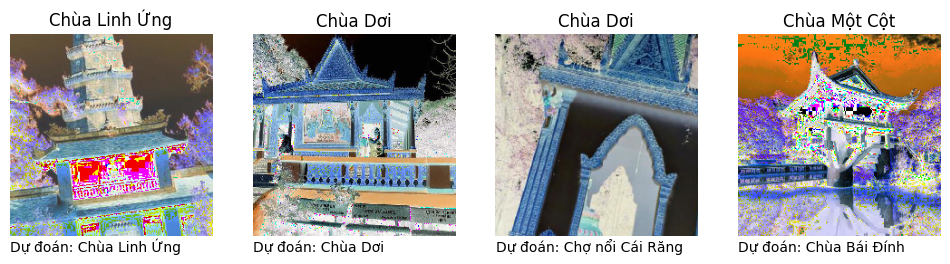

In [622]:
with torch.no_grad():
    outputs = model(images)

_, predicted = torch.max(outputs, 1)

num_images = len(images)
fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

# Hiển thị từng ảnh
for i in range(num_images):
    img = torchvision.transforms.ToPILImage()(images[i])  # Chuyển tensor về ảnh PIL
    axes[i].imshow(img)
    axes[i].set_title(f'{classes[labels[i].item()]}')
    axes[i].axis('off')
    axes[i].text(00, 240, f'Dự đoán: {classes[predicted[i].item()]}')
